In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, Deconvolution2D, Flatten, Dense, BatchNormalization
from keras.layers import Activation, Reshape, LeakyReLU, UpSampling2D
from pvlib.solarposition import get_solarposition
from keras.layers.core import K
from keras.optimizers import Adam
from scipy.stats import norm

Using TensorFlow backend.


In [2]:
tsi_data = xr.open_mfdataset("/scratch/dgagne/arm_tsi_sgp_nc/*.nc")

In [276]:
tsi_data.close()

In [3]:
tsi_times = pd.DatetimeIndex(tsi_data["time"].values)

In [4]:
tsi_data["tsi_image"].shape

(72435, 480, 480, 3)

In [16]:
sgp_lat = 36.605
sgp_lon = -97.485
altitude = 318
tsi_solpos = get_solarposition(tsi_times, sgp_lat, sgp_lon, alitude=altitude)

In [17]:
tsi_solpos

,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
2014-01-01 13:47:00,0.488056,89.511944,119.101002,0.008030,-3.576281,89.991970
2014-01-01 13:47:30,0.563242,89.436758,119.175539,0.095667,-3.576445,89.904333
2014-01-01 13:48:00,0.638762,89.361238,119.250150,0.183240,-3.576609,89.816760
2014-01-01 13:48:30,0.714614,89.285386,119.324837,0.270750,-3.576773,89.729250
2014-01-01 13:49:00,0.790796,89.209204,119.399599,0.358195,-3.576937,89.641805
2014-01-01 13:49:30,0.867301,89.132699,119.474437,0.445577,-3.577101,89.554423
2014-01-01 13:50:00,0.944121,89.055879,119.549351,0.532893,-3.577265,89.467107
2014-01-01 13:50:30,1.021248,88.978752,119.624342,0.620145,-3.577428,89.379855
2014-01-01 13:51:00,1.098671,88.901329,119.699410,0.707332,-3.577592,89.292668
2014-01-01 13:51:30,1.176380,88.823620,119.774554,0.794454,-3.577756,89.205546


In [4]:
tsi_patch = tsi_data["tsi_image"][::2, 100:100+32, 280:280+32]

In [287]:
tsi_patch.shape

(36218, 128, 128, 3)

In [9]:
t_size = 32768
b_size = 256
n_epochs = 100
K.set_learning_phase(0)
opt = Adam(lr=0.0002, beta_1=0.5)
dopt = Adam(lr= 0.0002, beta_1=0.5)
def make_trainable(net, val):
    for l in net.layers:
        l.trainable = val
        
def generator_model_conv():
    model = Sequential()
    model.add(Dense(input_shape=(100,), output_dim=64 * 2 * 2))
    model.add(Reshape((2, 2, 64)))
    model.add(Convolution2D(64, 5, 5, border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Convolution2D(32, 5, 5, border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Convolution2D(16, 5, 5, border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Convolution2D(8, 5, 5, border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Convolution2D(3, 5, 5, border_mode="same"))
    model.add(Activation("tanh"))
    return model

def generator_model(batch_size):
    model = Sequential()
    model.add(Dense(input_shape=(100,), output_dim=256 * 2 * 2))
    model.add(Reshape((2, 2, 256)))
    model.add(Deconvolution2D(256, 3, 3, output_shape=(batch_size, 4, 4, 256), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(128, 3, 3, output_shape=(batch_size, 8, 8, 128), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(64, 3, 3, output_shape=(batch_size, 16, 16, 64), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(32, 3, 3, output_shape=(batch_size, 32, 32, 32), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(16, 3, 3, output_shape=(batch_size, 64, 64, 16), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(8, 3, 3, output_shape=(batch_size, 128, 128, 8), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(3, 5, 5, output_shape=(batch_size, 128, 128, 3), border_mode="same"))
    model.add(Activation("tanh"))
    return model

def generator_model_small(batch_size):
    model = Sequential()
    model.add(Dense(input_shape=(100,), output_dim=64 * 2 * 2))
    model.add(Reshape((2, 2, 64)))
    model.add(Deconvolution2D(32, 5, 5, output_shape=(batch_size, 4, 4, 32), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Deconvolution2D(16, 5, 5, output_shape=(batch_size, 8, 8, 16), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Deconvolution2D(8, 5, 5, output_shape=(batch_size, 16, 16, 8), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(3, 5, 5, output_shape=(batch_size, 32, 32, 3), subsample=(2,2), border_mode="same"))
    model.add(Activation("tanh"))
    return model


def discriminator_model_small():
    model = Sequential()
    model.add(Convolution2D(8, 5, 5, subsample=(2, 2), input_shape=(32, 32, 3), border_mode="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(16, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    return model

def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(8, 3, 3, subsample=(2,2), input_shape=(128, 128, 3), border_mode="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(16, 3, 3, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(32, 3, 3, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(64, 3, 3, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(128, 3, 3, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(256, 3, 3, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    return model

def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    for layer in generator.layers:
        model.add(layer)
    for layer in discriminator.layers:
        layer.trainable = False
        model.add(layer)
    return model

In [5]:
train_data = tsi_patch[:32768]

In [6]:
train_data_scaled = 2 * ((train_data - train_data.min()) / (train_data.max() - train_data.min())) - 1

In [7]:
train_data_small = train_data_scaled[:, :32, :32]

In [ ]:
train_data_small = train_data_small.values

In [120]:
np.arange(b_size, t_size + b_size, b_size)

array([  256,   512,   768,  1024,  1280,  1536,  1792,  2048,  2304,
        2560,  2816,  3072,  3328,  3584,  3840,  4096,  4352,  4608,
        4864,  5120,  5376,  5632,  5888,  6144,  6400,  6656,  6912,
        7168,  7424,  7680,  7936,  8192,  8448,  8704,  8960,  9216,
        9472,  9728,  9984, 10240, 10496, 10752, 11008, 11264, 11520,
       11776, 12032, 12288, 12544, 12800, 13056, 13312, 13568, 13824,
       14080, 14336, 14592, 14848, 15104, 15360, 15616, 15872, 16128,
       16384, 16640, 16896, 17152, 17408, 17664, 17920, 18176, 18432,
       18688, 18944, 19200, 19456, 19712, 19968, 20224, 20480, 20736,
       20992, 21248, 21504, 21760, 22016, 22272, 22528, 22784, 23040,
       23296, 23552, 23808, 24064, 24320, 24576, 24832, 25088, 25344,
       25600, 25856, 26112, 26368, 26624, 26880, 27136, 27392, 27648,
       27904, 28160, 28416, 28672, 28928, 29184, 29440, 29696, 29952,
       30208, 30464, 30720, 30976, 31232, 31488, 31744, 32000, 32256,
       32512, 32768]

In [ ]:
disc = discriminator_model_small()
disc.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
gen = generator_model_small(b_size)
gen.compile(loss="binary_crossentropy", optimizer="adam")
print(gen.summary())
print(disc.summary())
disc_on_gen = generator_containing_discriminator(gen, disc)
disc_on_gen.compile(loss="binary_crossentropy", 
                       optimizer="adam",
                       metrics=["accuracy"])
print(disc_on_gen.summary())
sample_images = np.zeros(np.concatenate([[n_epochs], train_data_small.shape[1:]]))
g_loss = np.zeros((n_epochs, 2))
d_loss = np.zeros((n_epochs, 2))
train_order = np.arange(t_size)
combo_data = np.zeros(np.concatenate(([train_data_small.shape[0] * 2], train_data_small.shape[1:])))
combo_data[:t_size] = train_data_small[:t_size]
#labels = np.zeros(combo_data.shape[0], dtype=int)
#labels[:t_size] = 1
combo_data_batch = np.zeros(np.concatenate(([ 2 * b_size], train_data_small.shape[1:])))
batch_labels = np.zeros(2 * b_size)
batch_labels[:b_size] = 1
for ep in range(0, n_epochs):
    print("Epoch {0}/{1}".format(ep + 1, n_epochs))
    print(disc.layers[-2].get_weights()[0][0,0], gen.layers[0].get_weights()[0][0, 0])
    noise = np.random.uniform(-1, 1, size=(t_size, 100))
    np.random.shuffle(train_order)
    for b_index in np.arange(b_size, t_size + b_size, b_size):
        #print(b_index,)
        gen_noise = np.random.uniform(-1, 1, size=(b_size, 100))
        combo_data_batch[:b_size] = train_data_small[train_order[b_index-b_size:b_index]]
        combo_data_batch[b_size:] = gen.predict(noise[b_index-b_size:b_index], batch_size=b_size)
        #for layer in disc.layers:
        #    layer.trainable = True
        #disc.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
        d_loss[ep, :] += disc.train_on_batch(combo_data_batch, batch_labels)
        #for layer in disc.layers:
        #    layer.trainable = False
        #disc_on_gen.compile(loss="binary_crossentropy", 
        #                   optimizer="adam",
        #                   metrics=["accuracy"])
        g_loss[ep, :] += disc_on_gen.train_on_batch(gen_noise, np.ones(b_size))
    sample_images[ep] = combo_data_batch[b_size + 2]
    d_loss[ep, :] /= t_size / b_size
    g_loss[ep, :] /=  t_size / b_size
    print(d_loss[ep, :])
    print(g_loss[ep, :])
    print(disc.layers[-2].get_weights()[0][0,0], gen.layers[0].get_weights()[0][0, 0])

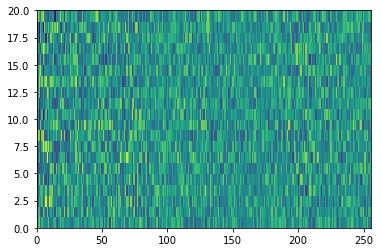

In [112]:
plt.pcolormesh(gen.layers[0].get_weights()[0])

In [229]:
d_loss.history

{'acc': [0.97388980263157898], 'loss': [0.1099121388121459]}

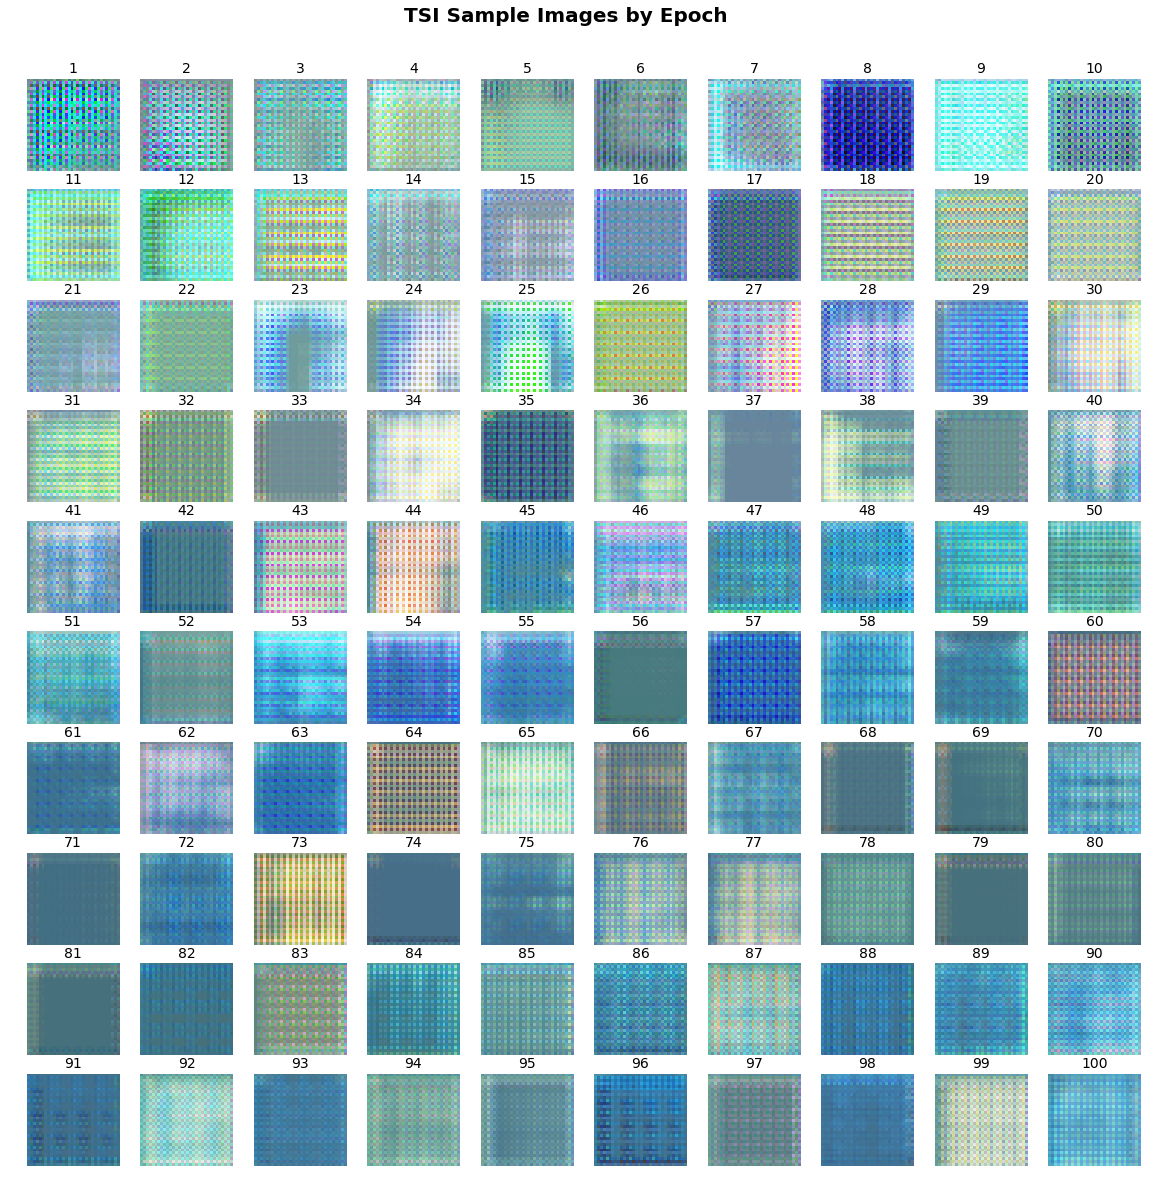

In [154]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for a, ax in enumerate(axes.ravel()):
    ax.imshow(((sample_images[a] + 1) / 2 * 255).astype("uint8") )
    ax.axis("off")
    ax.set_title("{0:d}".format(a + 1), fontsize=14)
fig.suptitle("TSI Sample Images by Epoch", fontsize=20, fontweight="bold", y=0.93)
plt.savefig("cloud_series_2.png", dpi=300, bbox_inches="tight")

In [132]:
combo_data_batch.shape

(512, 32, 32, 3)

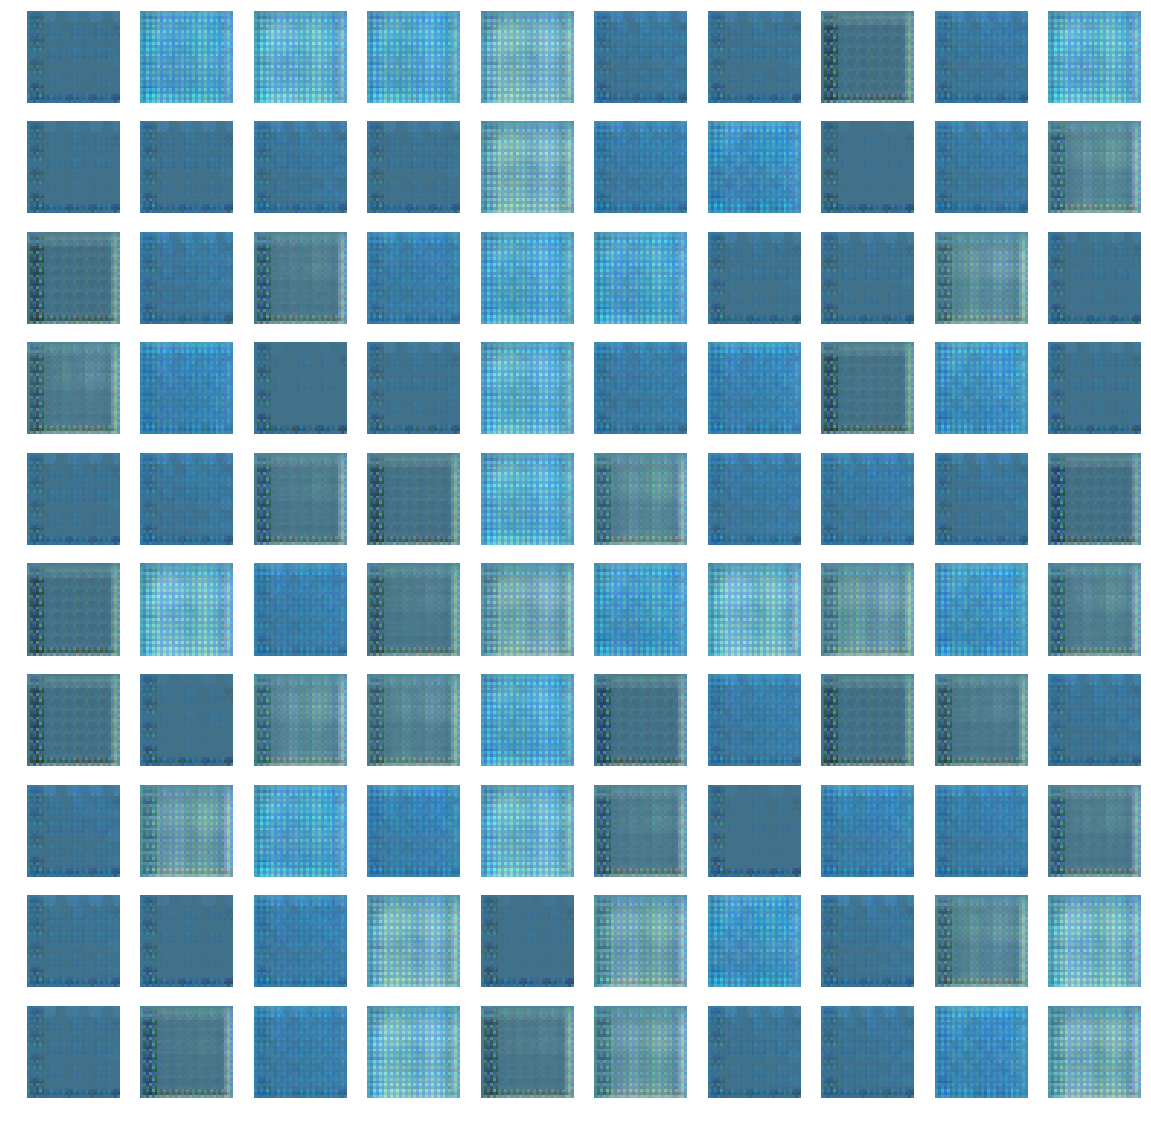

In [152]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for a, ax in enumerate(axes.ravel()):
    ax.imshow(((combo_data_batch[b_size + a] + 1) / 2 * 255).astype("uint8") )
    ax.axis("off")
plt.savefig("cloud_samples.png", dpi=300, bbox_inches="tight")

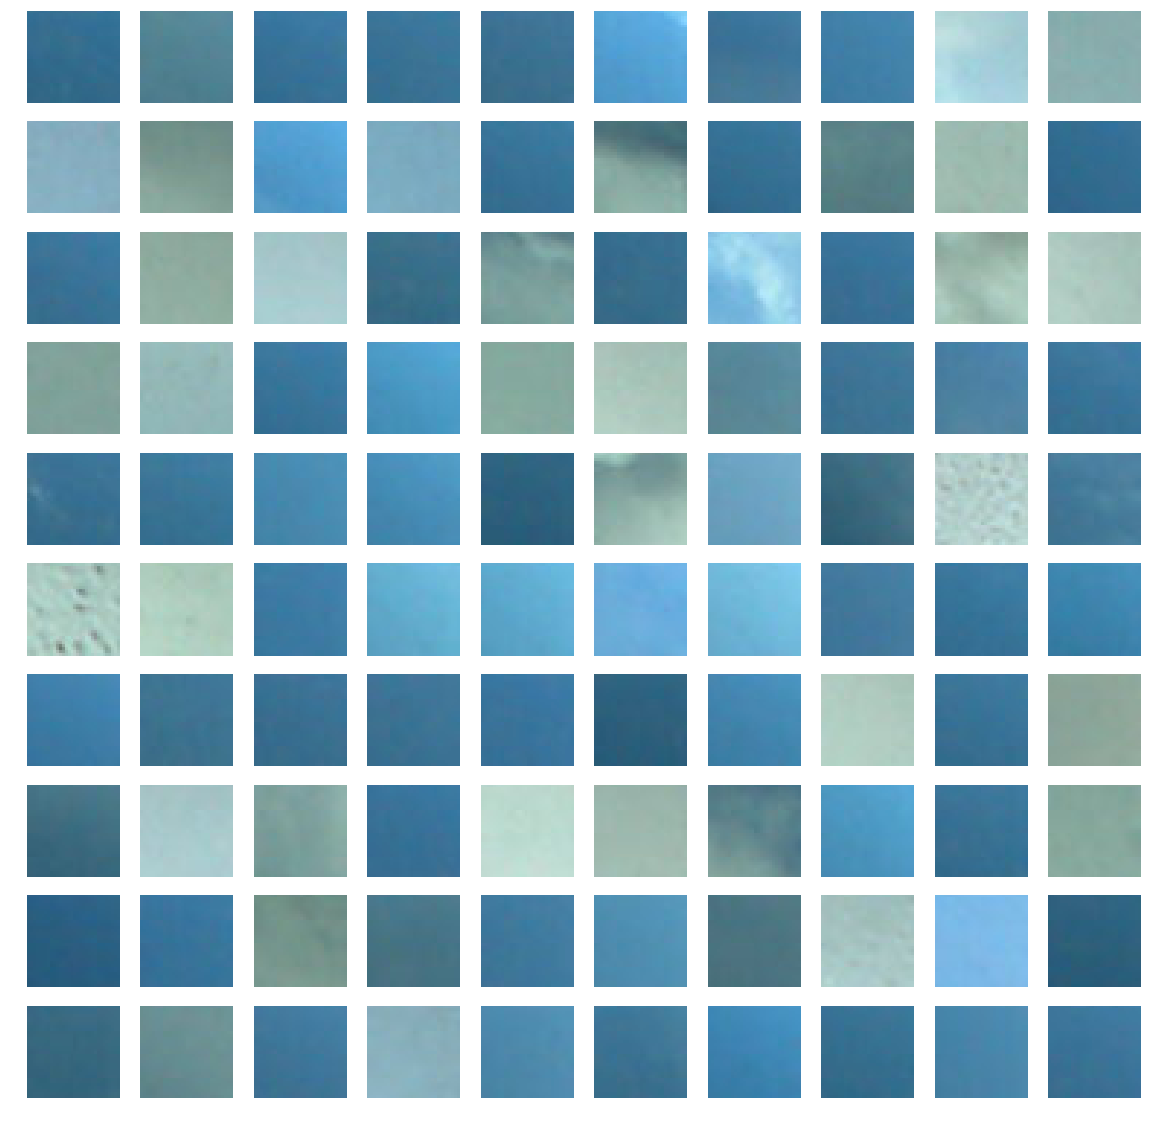

In [147]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
real_sampled_images = train_data_small[np.random.choice(train_data_small.shape[0], size=100, replace=False)] 
for a, ax in enumerate(axes.ravel()):
    ax.imshow(((real_sampled_images[a]+ 1) / 2 * 255).astype("uint8") )
    ax.axis("off")
plt.savefig("cloud_samples_real.png", dpi=300, bbox_inches="tight")

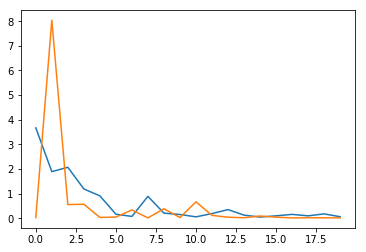

In [17]:
plt.plot(g_loss[:,0])
plt.plot(d_loss[:,0])

In [140]:
np.random.shuffle(training_order)
training_order

array([ 707, 1477, 3850, ..., 1223, 4657, 3562])

In [219]:
d_loss.history

{'acc': [0.97388980263157898], 'loss': [0.1099121388121459]}